# Code du Module 7 : l'apprentissage non supervisé

Ce notebook présente tous les morceaux de code utilisés dans les slides du cours du module 7. Vous pouvez ainsi les copier/coller, et les modifier pour tester leurs fonctionnalités à votre guise.


In [1]:
import os
# Définir la variable d'environnement
os.environ["OMP_NUM_THREADS"] = "1" # Éviter fuite de mémoire / Microsoft Windows (nécessite redémarrage du Kernel)

#import des librairies
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

Pour ce module, nous allons à nouveau utiliser le jeu de données Iris. Cependant, comme il s'agit de tester des algorithmes de classification non supervisée, nous nous contenterons de charger les attributs, sans les labels. Pour simplifier cet exemple, nous ne garderons que deux attributs : petal_width et sepal_width.

In [2]:
#Import des données nécessaires
X, _ = load_iris(return_X_y=True, as_frame=True)

X = X[['petal width (cm)', 'sepal width (cm)']]

## Clustering kmeans

In [3]:
# Creation du modèle
km = KMeans(n_clusters=3, init='k-means++')

# Apprentissage des clusters
km.fit(X)

# Pour chaque point, récupérer le numéro du cluster auquel il est affecté
clusters_points = km.predict(X)

# Ajouter le numéro de cluster au dataframe
X['y_kmeans'] = clusters_points

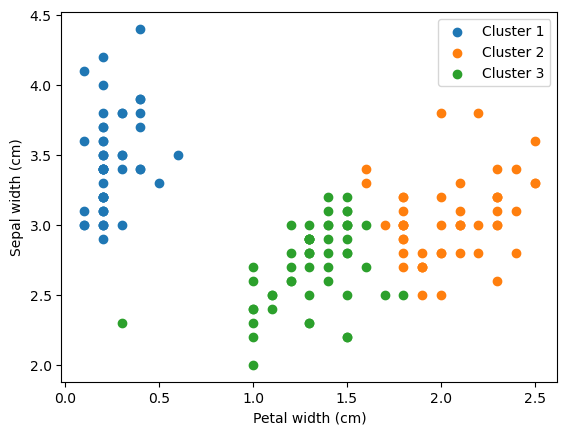

In [4]:
for i in range(3):
    plt.scatter(X[X['y_kmeans']==i]['petal width (cm)'], X[X['y_kmeans']==i]['sepal width (cm)'], label='Cluster '+str(i+1))

plt.xlabel('Petal width (cm)')
plt.ylabel('Sepal width (cm)')
plt.legend()
plt.show()

## Clustering hiérarchique

Dans l'implémentation avec scikit-learn, il est nécessaire d'indiquer le nombre de clusters dès le départ (=niveau de coupe dans le dendrogramme, condition d'arrêt de l'algorithme).

Autre particularité : pas de `predict` ! Le dendrogramme n'existe que pour les données fournies, impossible de rattacher facilement un nouveau point aux clusters créés.

In [5]:
# Creation du modèle
hierarchical = AgglomerativeClustering(n_clusters=1)

# Apprentissage des clusters
clusters_points = hierarchical.fit_predict(X)

Définition d'une méthode pour l'affichage d'un dendrogramme

In [6]:
def plot_dendrogram(model, **kwargs):
    """Génère un dendrogramme à partir d'un modèle de clustering hiérarchique (AgglomerativeClustering).
    
    Paramètres :
    - model : un objet de clustering hiérarchique ajusté (par ex. AgglomerativeClustering).
    - kwargs : arguments optionnels pour personnaliser le dendrogramme (transmis à scipy.cluster.hierarchy.dendrogram).
    
    Retour :
    - Affiche un dendrogramme représentant les regroupements successifs.
    """

    # Étape 1 : Initialiser un tableau pour compter le nombre d'échantillons dans chaque nœud
    counts = np.zeros(model.children_.shape[0]) # `counts` va contenir, pour chaque nœud interne, le nombre d'échantillons regroupés.

    n_samples = len(model.labels_) # Nombre total d'échantillons dans les données d'entrée

    # Étape 2 : Calculer le nombre d'échantillons dans chaque nœud interne
    for i, merge in enumerate(model.children_):  # `model.children_` contient les indices des nœuds fusionnés à chaque étape.
        current_count = 0
        for child_idx in merge:  # Parcourt les deux enfants du nœud courant.
            if child_idx < n_samples: # Si l'indice de l'enfant correspond à une feuille (échantillon initial)…
                current_count += 1 # on ajoute 1 au compteur.
            else: # Sinon l'indice de l'enfant correspond à un nœud interne,
                current_count += counts[child_idx - n_samples] # on ajoute le nombre d'échantillons déjà comptés pour ce nœud.
        counts[i] = current_count # Stocker le nombre total d'échantillons pour le nœud courant.

    # Étape 3 : Construire une matrice de liaison au format attendu par `dendrogram`
    # `linkage_matrix` est une matrice où chaque ligne correspond à une fusion entre deux nœuds :
    # - Les deux premiers colonnes indiquent les indices des nœuds fusionnés.
    # - La troisième colonne indique la distance entre ces deux nœuds.
    # - La quatrième colonne contient le nombre d'échantillons fusionnés dans ce nœud.
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Étape 4 : Générer et afficher le dendrogramme en utilisant la matrice de liaison
    dendrogram(linkage_matrix, **kwargs) # La fonction `dendrogram` de SciPy est utilisée pour tracer l'arbre.


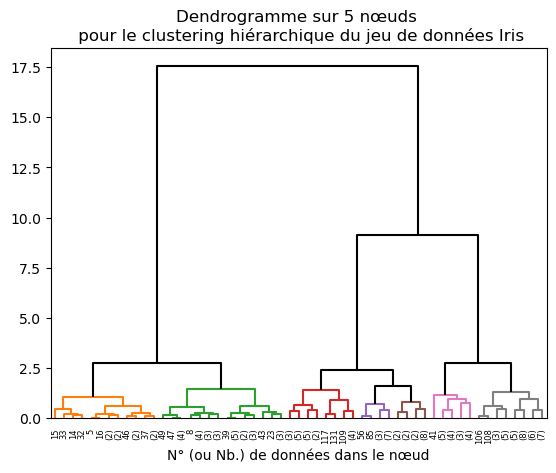

In [7]:
# Création d'un modèle de clustering hiérarchique sans fixer de nombre de clusters
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# distance_threshold=0 : permet de calculer toutes les fusions possibles (arbre complet)
# n_clusters=None : indique que nous ne fixons pas de nombre de clusters final

model = model.fit(X) # Ajustement du modèle sur les données
nb_nodes = 5 # Nombre de niveaux (profondeur) que l'on souhaite afficher dans le dendrogramme

# Titre du graphique avec une description explicite
plt.title(F"Dendrogramme sur {nb_nodes} nœuds \n pour le clustering hiérarchique du jeu de données Iris")

# Affichage du dendrogramme avec un mode de troncature (truncate_mode) pour limiter à la profondeur souhaitée
plot_dendrogram(model, truncate_mode="level", p=nb_nodes, color_threshold=1.5, above_threshold_color='black')
# truncate_mode="level" : coupe l'affichage du dendrogramme à un certain niveau de l'arbre
# p=depth : limite l'affichage à `depth` niveaux depuis les feuilles

# Ajout d'un label pour l'axe des abscisses
plt.xlabel("N° (ou Nb.) de données dans le nœud")

# Affichage du graphique
plt.show()

In [8]:
print("Distances entre clusters à chaque étape de fusion :")
print(model.distances_)

Distances entre clusters à chaque étape de fusion :
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.1         0.1
  0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.1         0.1         0.1         0.1
  0.1         0.11547005  0.11547005  0.11547005  0.11547005  0.11547005
  0.11547005  0.11547005  0.11547005  0.11547005  0.12247449  0.12247449
  0.12247449  0.12247449  0.12649111  0.12909944  0.13038405  0.13038405
  0.1414213

## Itemsets et associations (⚠ en construction…)
- Importation de bibliothèque MLXtend (https://rasbt.github.io/mlxtend/).
- Chargement ou simulation d'un dataset de transactions.
- Extraction des itemsets fréquents avec l'algorithme Apriori.
- Génération des règles d'association.
- Interprétation des résultats avec des visualisations.

In [9]:
# Installation de la librairie MLXTEND :
# pip install mlxtend scikit-learn
# pip install mlxtend scikit-learn --trusted-host pypi.org --trusted-host files.pythonhosted.org # ⚠Contourner la vérification SSL
# conda install -c conda-forge mlxtend

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [10]:
# Création du jeu de données
# Exemple de transactions (chaque sous-liste représente les articles achetés par un client)
transactions = [
    ["pain", "lait", "beurre"],
    ["pain", "lait"],
    ["lait", "beurre", "bière"],
    ["pain", "confiture"],
    ["lait", "confiture", "beurre", "bière"],
    ["pain", "lait", "confiture", "beurre"],
    ["lait", "couche bébé", "bière"],
    ["pain", "beurre", "bière"],
    ["confiture", "couche bébé", "beurre", "bière"],
    ["pain", "couche bébé", "lait"],
]

# Transformation en un tableau binaire pour l'analyse
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df = pd.DataFrame(te_array, columns=te.columns_)

print("Tableau binaire des transactions :")
print(df)

Tableau binaire des transactions :
   beurre  bière  confiture  couche bébé   lait   pain
0    True  False      False        False   True   True
1   False  False      False        False   True   True
2    True   True      False        False   True  False
3   False  False       True        False  False   True
4    True   True       True        False   True  False
5    True  False       True        False   True   True
6   False   True      False         True   True  False
7    True   True      False        False  False   True
8    True   True       True         True  False  False
9   False  False      False         True   True   True


In [11]:
# Détection des itemsets fréquents (min_support = seuil minimal de fréquence)
itemsets = apriori(df, min_support=0.4, use_colnames=True)
print("\nItemsets fréquents :")
print(itemsets)


Itemsets fréquents :
   support         itemsets
0      0.6         (beurre)
1      0.5          (bière)
2      0.4      (confiture)
3      0.7           (lait)
4      0.6           (pain)
5      0.4  (beurre, bière)
6      0.4   (lait, beurre)
7      0.4     (pain, lait)


## Explication des critères des règles d'association
- `Antecedents` : Les produits qui apparaissent dans le premier ensemble de la règle.
- `Consequents` : Les produits qui apparaissent dans le second ensemble de la règle, en fonction des antecedents.
- `Support` : Proportion de transactions contenant à la fois les antecedents et les consequents.
- `Confidence` : Proportion des transactions contenant le consequent parmi celles contenant les antecedents.
- `Lift` : Mesure de l'augmentation de la probabilité d'achat du consequent en présence des antecedents, comparé à l'indépendance.

In [12]:
# Calcul des règles d'association à partir des itemsets fréquents
rules = association_rules(itemsets, num_itemsets=len(itemsets), metric='lift', min_threshold=1.0)

print("\nRègles d'association :")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Règles d'association :
  antecedents consequents  support  confidence      lift
0    (beurre)     (bière)      0.4    0.666667  1.333333
1     (bière)    (beurre)      0.4    0.800000  1.333333


### Règle 1 :
- `Antecedents` : (bière) / `Consequents` : (beurre)
- `Support` : 0.4 (40% des transactions contiennent à la fois bière et beurre.)
- `Confidence` : 0.8 (80% des transactions contenant bière contiennent aussi beurre.)
- `Lift` : 1.33 (La probabilité d'acheter beurre en présence de bière est 33% plus élevée que si ces deux produits étaient indépendants.)

### Règle 2 :
- `Antecedents` : (beurre) / `Consequents` : (bière)
- `Support` : 0.4 (40% des transactions contiennent à la fois beurre et bière.)
- `Confidence` : 0.67 (67% des transactions contenant beurre contiennent aussi bière.)
- `Lift` : 1.33 (La probabilité d'acheter bière en présence de beurre est 33% plus élevée que si ces deux produits étaient indépendants.)

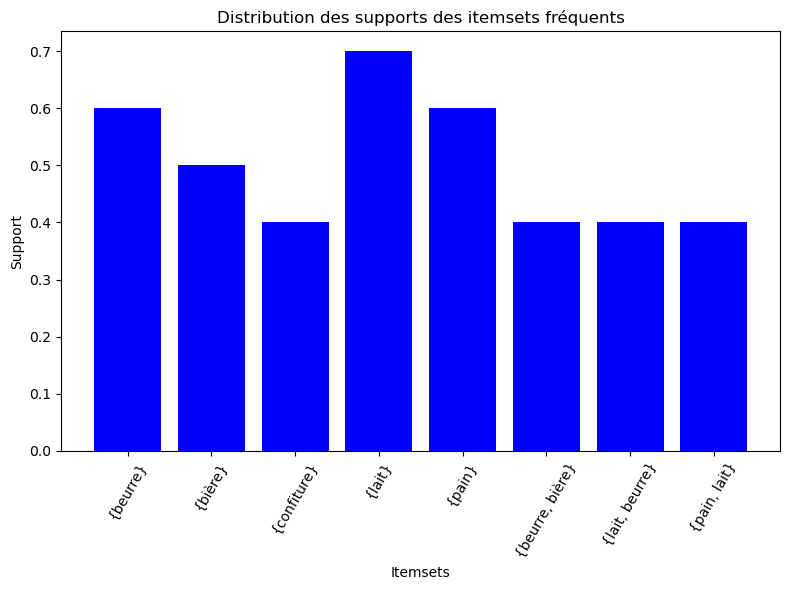

In [13]:
# Convertir les frozensets en chaînes de caractères simples sans 'frozenset()'
labels = itemsets['itemsets'].apply(lambda x: f"{{{', '.join(x)}}}").astype(str)

# Distribution du support des itemsets
plt.figure(figsize=(8, 6))
plt.bar(labels, itemsets['support'], color='b')
plt.title("Distribution des supports des itemsets fréquents")
plt.xlabel("Itemsets")
plt.ylabel("Support")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()